In [8]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sys
import os
import collections
import json
import re
import pprint
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
%matplotlib inline 

In [5]:
# parse json to files and actions

def parse_json(filepath):
    '''
    function used to parse json of each commit json file
    
    Args:
        filepath_list - list of filepaths
    
    Returns:
        files_json - list object contains parsed information
    
    '''
    number_of_files = []
    files_json = []
    
    # each commits
    files = os.listdir(filepath)
    for path in files:
        with open(filepath + path,'rb') as f:
            data = json.load(f)
            files_list = []
            # each file in commits
            for file in data['files']:
                # parse only cluster file
                for key in file.keys():
                    if re.match('^.*_cluster$',key):
                        actions_list = []
                        actions = file[key]['actions']
                        # each action in file
                        for action in actions:
                            actions_list.append(action['root'])
                        files_list.append(actions_list)
        
        files_json.append(files_list)        
    
    # return
    return files_json
pwd = os.getcwd()
folder_path = pwd + '/tmp_JSON_labeled_commits/'
files = parse_json(folder_path)
print(files[0])

[['INS Block to MethodDeclaration at 6', 'MOVE from Block', 'MOVE from Block', 'UPDATE from add to addEvent', 'INS Block to EnhancedForStatement at 2', 'MOVE from Block', 'DEL SimpleName: externalEventQueue', 'DEL Block', 'DEL SimpleName: externalEventQueue', 'DEL Block'], ['MOVE from Block', 'UPDATE from triggerEvent to addEvent', 'MOVE from Block', 'DEL TryStatement', 'DEL TryStatement'], ['MOVE from MethodDeclaration', 'MOVE from Block', 'MOVE from Block', 'UPDATE from triggerEvent to addEvent', 'DEL TryStatement', 'DEL Block']]


In [6]:
def preprocess_roots(files_data):
    counting = {}
    for file_index, files in enumerate(files_data):
        for root_index, roots in enumerate(files):
            for action_index, actions in enumerate(roots):
                temp = actions.split(' at ')[0]
                tempq = []
                if temp.startswith('INS'):
                    tempq.append('INS')
                    words = [temp.split('INS ')[1].split(' to ')[0]
                             ] + [temp.split('INS ')[1].split(' to ')[-1]]
                    for items in words:

                        items = items.split(': ')[0]
                        tempq.append(items)
                    temp = '_'.join(tempq)

                if temp.startswith('UPDATE'):
                    temp = 'UPDATE'
                if temp.startswith('MOVE'):
                    temp2 = temp.split(' from ')[1]
                    tempq.append('MOVE')
                    tempq.append(temp2.split(': ')[0])
                    temp = '_'.join(tempq)

                if temp.startswith('DEL'):
                    tempq.append('DEL')
                    tempq.append(temp.split('DEL ')[1].split(': ')[0])
                    temp = '_'.join(tempq)
                counting[temp] = counting.get(temp, 0) + 1
                files_data[file_index][root_index][action_index] = temp
    dic = {}
    i = 0
    for k, v in counting.items():
        dic[k] = i  
        i += 1
    return dic, files_data

dic, datas = preprocess_roots(files)

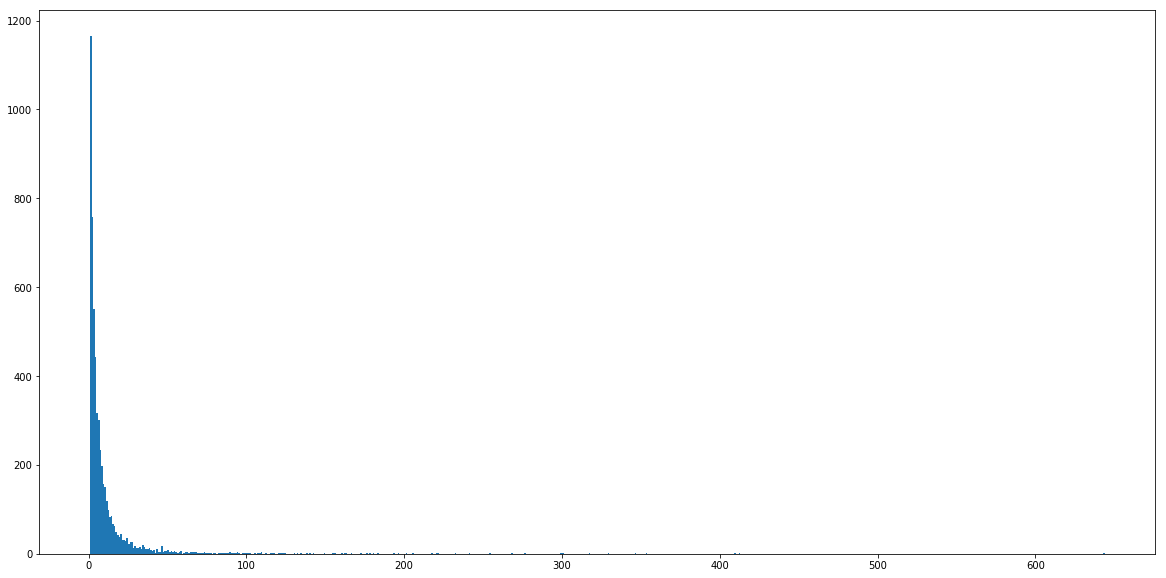

In [7]:
def actions2sentence(datas):
    data_total = []
    for files in datas:
        data4file = []
        for roots in files:
            sentence = ' '.join(roots)
            data4file.append(sentence)
        data_total.append(data4file)
    return data_total


training_data = actions2sentence(datas)

def get_seqlength(training_data):
    max_root_len = 0
    seqlength_list = []
    for items in training_data:
        for item in items:
            seqlength_list.append(len(item.split(" ")))
            if len(item.split(" ")) >  max_root_len: 
                max_root_len = len(item.split(" "))
    return max_root_len, seqlength_list

def plot_hist(seqlength_list): 
    plt.figure(figsize=(20,10))
    number_of_files = np.array(seqlength_list)
    bincount = np.bincount(seqlength_list)
    x = np.arange(1, len(bincount)+1)
    n, bins, patches = plt.hist(seqlength_list,x)

max_seqlength, sequence_list = get_seqlength(training_data)
plot_hist(sequence_list)
    
# for keys, vals in dic.items(): 
#     print(keys, vals)
  
